# 10 Time Series forecast with convolutional Neural Networks (CNN)

1D Convolution neural networks can be used for time series forecast. The kernel(s) sweeps the data space (samples, features) and make summaries (learns) of different parts of the data. This process is known as feature learning or feature extraction.

I read the data after the preliminary EDA performed as part of the project proposal.

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Conv1D, Dropout, MaxPooling1D

from tensorflow.keras import optimizers, losses, metrics
import tensorflow.keras as keras
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
    
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.filterwarnings('ignore')
import dill as pickle

from tempfile import mkdtemp
from shutil import rmtree

In [2]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

with tf.enable_eager_execution() operations are executed immediately as they are called from Python.

In [3]:
tf.enable_eager_execution()

In [5]:
data = pd.read_pickle('tidy_dataframe_capstone.csv')

In [5]:
data.head()

,Weekday,Season,Year,Month,Day,Hour,SO2,NO2,CO,O3,...,it_rained,Lag-1,Lag-2,Lag-3,Lag-4,Lag-5,Lag-6,Lag-7,Lag-8,EMA
Date and Time,,,,,,,,,,,,,,,,,,,,,
2013-03-01 08:00:00,Friday,winter,2013,3,1,8,9.0,23.0,300.0,50.0,...,0,8.0,8.0,10.0,8.0,8.0,8.0,11.0,9.0,8.091904
2013-03-01 09:00:00,Friday,winter,2013,3,1,9,10.0,18.0,300.0,56.0,...,0,3.0,8.0,8.0,10.0,8.0,8.0,8.0,11.0,7.569890
2013-03-01 10:00:00,Friday,winter,2013,3,1,10,11.0,15.0,300.0,61.0,...,0,3.0,3.0,8.0,8.0,10.0,8.0,8.0,8.0,7.142810
2013-03-01 11:00:00,Friday,winter,2013,3,1,11,9.0,14.0,300.0,62.0,...,0,3.0,3.0,3.0,8.0,8.0,10.0,8.0,8.0,6.786929
2013-03-01 12:00:00,Friday,winter,2013,3,1,12,8.0,10.0,300.0,67.0,...,0,3.0,3.0,3.0,3.0,8.0,8.0,10.0,8.0,6.485818


I read the training and the test set.

In [8]:
X_tr_valid = np.load('X_tr_imputed.npy')
y_tr_valid = np.load('y_tr.npy')

# X_valid = np.load('features_valid.npy')
# y_valid = np.load('labels_valid.npy')

X_test = np.load('X_te_imputed.npy')
y_test = np.load('y_te.npy')

In [9]:
df_tr = pd.read_pickle('training_dataset_df.csv')

I define the quantile transformation and the columns of the future matrix that it will be applied.

In [10]:
# qt_columns = ['SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'WSPM', 'PM10']
qt_columns = [6,7,8,9,10,11,12,15,16] # column indexes
qt = QuantileTransformer(n_quantiles = 1000, random_state = 0)

I apply the Quantile transformation of n = 1000 quantiles to the target vector. The Quantile-transformed target vector is y_tr_qt.

In [11]:
y_tr_valid_qt = qt.fit_transform(y_tr_valid.reshape(-1, 1))[:,0]
y_tr_valid_qt.shape

(30704,)

In [12]:
y_test_qt = qt.fit_transform(y_test.reshape(-1, 1))[:,0]

In [13]:
y_tr_valid.shape

(30704,)

In [14]:
y_tr_valid.reshape(-1, 1).shape

(30704, 1)

In [15]:
X_tr_valid.shape

(30704, 46)

In [16]:
len(X_tr_valid)

30704

In [17]:
# Mean Absolute error (MAE)
def MAE(y,y_pred):    
    return(np.mean(np.abs(y-y_pred)))

def RSS(y,y_pred):
    # score = MAE(np.exp(y),np.exp(y_pred)) # Invert log-transformation and compute MAE 
    # score = RSS(y_test, qt.inverse_transform(y_pred)) # invert QuantileTransformation
    score = np.sum(np.square(y - y_pred))# invert QuantileTransformation
    # y_test does not need to be transformed
    return score

def R2_score(y,y_pred, y_train):
    score = 1-(RSS(y, y_pred)/RSS(y,y_train.mean()))
    return score      

Data preprocessing

In [19]:
n_features = X_tr_valid.shape[1]

I will use the following CNN with one convolutional layer, one hidden layer (dense) and an output layer of 1 unit, since I want to predict one variable namely PM2.5.

In [20]:
def build_model(learning_rate=0.01):
    model = Sequential()
    model.add(Conv1D(64, kernel_size = 4, activation='relu', input_shape=(n_features, 1))) 
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation = 'linear')) # output layer, 'linear' for regression
    opt = tf.train.AdamOptimizer(learning_rate)
    model.compile(optimizer = opt, loss='mae')
    #model.compile(optimizer = tf.train.AdamOptimizer(), loss='mae')
    # model.compile(loss='mean_squared_error', optimizer='adam') that did not wotk with later
    return model
# relu functions add nonlinearities
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 43, 64)            320       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 21, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1344)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                67250     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 67,621
Trainable params: 67,621
Non-trainable params: 0
_________________________________________________________________


In [33]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

In [34]:
estimator = KerasRegressor(build_fn = build_model, epochs=5, batch_size=64)
# estimator = KerasRegressor(build_fn = build_model, epochs=3, batch_size=64)

In [35]:
preprocessing_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('preprocessor', ColumnTransformer([('quantile', qt, qt_columns)], remainder='passthrough')),
    ('reshape', FunctionTransformer(lambda X: np.reshape(X, (X.shape[0], X.shape[1],1)))),
])

# prepare data: (sample, time steps, features)  --> not needed as added 'reshape' to pipeline 
# X_train = np.reshape(X_tr_valid_p, (X_tr_valid_p.shape[0], X_tr_valid_p.shape[1],1))
# X_test = np.reshape(X_te_p, (X_te_p.shape[0], X_te_p.shape[1],1))

In [36]:
full_pipeline = Pipeline([
    ('preprocassing', preprocessing_pipe), 
    ('cnn', estimator) # Grid search needed
])

In [37]:
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]

In [42]:
grid = dict(#optimizer=optimizers
                      cnn__learning_rate = learning_rate
                      #dropout_rate=dropout_rate, 
                      #epochs=epochs, 
                      #batch_size=batches, 
                      #weight_constraint=weight_constraint, 
                      #init=init
           )

In [43]:
tscv = TimeSeriesSplit(n_splits = 3)

I use n_jobs = 1. The value n_jobs=-1 means that the gridsearch should run explorations in parallel. Something that probably shouldn't be done for keras models, given that they also already run in parallel. So, only training one neural network at a time is probably the best approach, i.e. n_jobs=1.

In [44]:
grid_cv = GridSearchCV(full_pipeline, grid, cv = tscv, return_train_score = True, verbose = 2, n_jobs = 1, scoring = 'neg_mean_absolute_error')

In [45]:
grid_cv.fit(X_tr_valid, y_tr_valid_qt)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] cnn__learning_rate=0.001 ........................................
Epoch 1/5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


120/120 [==============================] - 3s 24ms/step - loss: 0.1441
Epoch 2/5
120/120 [==============================] - 3s 25ms/step - loss: 0.0850
Epoch 3/5
120/120 [==============================] - 3s 25ms/step - loss: 0.0731
Epoch 4/5
120/120 [==============================] - 3s 25ms/step - loss: 0.0739
Epoch 5/5
120/120 [==============================] - 3s 24ms/step - loss: 0.0673
[CV] ......................... cnn__learning_rate=0.001, total=  15.7s
[CV] cnn__learning_rate=0.001 ........................................
Epoch 1/5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.5s remaining:    0.0s


240/240 [==============================] - 6s 25ms/step - loss: 0.1123
Epoch 2/5
240/240 [==============================] - 6s 24ms/step - loss: 0.0756
Epoch 3/5
240/240 [==============================] - 6s 25ms/step - loss: 0.0677
Epoch 4/5
240/240 [==============================] - 6s 25ms/step - loss: 0.0660
Epoch 5/5
240/240 [==============================] - 6s 24ms/step - loss: 0.0660
[CV] ......................... cnn__learning_rate=0.001, total=  30.3s
[CV] cnn__learning_rate=0.001 ........................................
Epoch 1/5
360/360 [==============================] - 9s 24ms/step - loss: 0.1055
Epoch 2/5
360/360 [==============================] - 9s 24ms/step - loss: 0.0710
Epoch 3/5
360/360 [==============================] - 9s 25ms/step - loss: 0.0650
Epoch 4/5
360/360 [==============================] - 9s 24ms/step - loss: 0.0596
Epoch 5/5
360/360 [==============================] - ETA: 0s - loss: 0.056 - 9s 24ms/step - loss: 0.0562
[CV] ......................... cnn

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  7.6min finished


480/480 [==============================] - 11s 23ms/step - loss: 0.1148
Epoch 2/5
480/480 [==============================] - 11s 22ms/step - loss: 0.0688
Epoch 3/5
480/480 [==============================] - 11s 23ms/step - loss: 0.0712 1
Epoch 4/5
480/480 [==============================] - 11s 23ms/step - loss: 0.0644
Epoch 5/5
480/480 [==============================] - 11s 23ms/step - loss: 0.0658


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocassing', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('preprocessor', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('quantile', Quant...), ('cnn', <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f862753c4e0>)]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'cnn__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=2)

In [65]:
grid_cv.best_estimator_

Pipeline(memory=None,
     steps=[('preprocassing', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('preprocessor', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('quantile', Quant...), ('cnn', <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f860a56ee80>)])

In [66]:
grid_cv.cv_results_

{'mean_fit_time': array([29.48034898, 29.69913665, 27.2741847 , 27.17093778, 27.26720881]),
 'std_fit_time': array([11.79497155, 11.28192037, 11.19602311, 11.04657375, 11.10948783]),
 'mean_score_time': array([0.74577896, 0.73763394, 0.73805467, 0.71774228, 0.7236073 ]),
 'std_score_time': array([0.01651288, 0.01598282, 0.01929432, 0.0037388 , 0.00058384]),
 'param_cnn__learning_rate': masked_array(data=[0.001, 0.01, 0.1, 0.2, 0.3],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'cnn__learning_rate': 0.001},
  {'cnn__learning_rate': 0.01},
  {'cnn__learning_rate': 0.1},
  {'cnn__learning_rate': 0.2},
  {'cnn__learning_rate': 0.3}],
 'split0_test_score': array([-0.06426841, -0.07769049, -0.25666469, -0.31478884, -0.65427148]),
 'split1_test_score': array([-0.10428446, -0.06055315, -0.25378049, -0.26508236, -0.25790259]),
 'split2_test_score': array([-0.05909838, -0.05564076, -0.25398492, -0.26769041, -0.32754751])

In [67]:
grid_cv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_cnn__learning_rate', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

In [70]:
cv_results = pd.DataFrame(grid_cv.cv_results_)
cols = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'param_cnn__learning_rate']
cv_results[cols].sort_values(by = 'mean_test_score', ascending = False).head()

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_cnn__learning_rate
1,-0.064628,0.009452,-0.070975,0.010951,0.01
0,-0.075884,0.020193,-0.060925,0.005872,0.001
2,-0.254810,0.001314,-0.261526,0.005595,0.1
3,-0.282521,0.022842,-0.291773,0.026651,0.2
4,-0.413241,0.172790,-0.276621,0.023630,0.3


In [72]:
cv_results = pd.DataFrame(grid_cv.cv_results_)
cols = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_test_score', 'param_cnn__learning_rate']
cv_results['mean_test_score'] = np.abs(cv_results['mean_test_score'])
cv_results['mean_train_score'] = np.abs(cv_results['mean_train_score'])
cv_results[cols].sort_values(by = 'mean_test_score', ascending = True).head(10)

,mean_test_score,std_test_score,mean_train_score,std_test_score,param_cnn__learning_rate
1,0.064628,0.009452,0.070975,0.009452,0.01
0,0.075884,0.020193,0.060925,0.020193,0.001
2,0.254810,0.001314,0.261526,0.001314,0.1
3,0.282521,0.022842,0.291773,0.022842,0.2
4,0.413241,0.172790,0.276621,0.172790,0.3


In [73]:
cv_results.to_pickle('CNNs_cv.csv')
cv_results.head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cnn__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,29.480349,11.794972,0.745779,0.016513,0.001,{'cnn__learning_rate': 0.001},-0.064268,-0.104284,-0.059098,0.075884,0.020193,2,-0.066877,-0.062964,-0.052935,0.060925,0.005872
1,29.699137,11.281920,0.737634,0.015983,0.01,{'cnn__learning_rate': 0.01},-0.077690,-0.060553,-0.055641,0.064628,0.009452,1,-0.080674,-0.076580,-0.055669,0.070975,0.010951
2,27.274185,11.196023,0.738055,0.019294,0.1,{'cnn__learning_rate': 0.1},-0.256665,-0.253780,-0.253985,0.254810,0.001314,3,-0.253627,-0.265875,-0.265076,0.261526,0.005595
3,27.170938,11.046574,0.717742,0.003739,0.2,{'cnn__learning_rate': 0.2},-0.314789,-0.265082,-0.267690,0.282521,0.022842,4,-0.324012,-0.292561,-0.258746,0.291773,0.026651


In [74]:
cv_results = pd.read_pickle('CNNs_cv.csv')
cv_results.head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cnn__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,29.480349,11.794972,0.745779,0.016513,0.001,{'cnn__learning_rate': 0.001},-0.064268,-0.104284,-0.059098,0.075884,0.020193,2,-0.066877,-0.062964,-0.052935,0.060925,0.005872
1,29.699137,11.281920,0.737634,0.015983,0.01,{'cnn__learning_rate': 0.01},-0.077690,-0.060553,-0.055641,0.064628,0.009452,1,-0.080674,-0.076580,-0.055669,0.070975,0.010951
2,27.274185,11.196023,0.738055,0.019294,0.1,{'cnn__learning_rate': 0.1},-0.256665,-0.253780,-0.253985,0.254810,0.001314,3,-0.253627,-0.265875,-0.265076,0.261526,0.005595
3,27.170938,11.046574,0.717742,0.003739,0.2,{'cnn__learning_rate': 0.2},-0.314789,-0.265082,-0.267690,0.282521,0.022842,4,-0.324012,-0.292561,-0.258746,0.291773,0.026651


In [76]:
mean_train = cv_results['mean_train_score']
mean_test = cv_results['mean_test_score']
std_train = cv_results['std_train_score']
std_test = cv_results['std_test_score']
learning_rate = cv_results['param_cnn__learning_rate']

std_plus = np.array((mean_test + std_test), dtype = float)
std_minus = np.array((mean_test - std_test), dtype = float)

In [77]:
index = mean_test.idxmin()
best_lr = cv_results['param_cnn__learning_rate'][index]
best_lr

0.01

In [78]:
grid_cv.best_estimator_.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('preprocassing', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('preprocessor', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('quantile', Quant...), ('cnn', <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f860a56ee80>)])>

In [80]:
scores = cv_results[['mean_test_score',  'std_test_score', 'mean_train_score', 'std_train_score', 'param_cnn__learning_rate']]

In [81]:
scores.columns = ['MAE_test','std_test_score', 'MAE_train', 'std_train_score',  'learning_rate']
scores.head()

,MAE_test,std_test_score,MAE_train,std_train_score,learning_rate
0,0.075884,0.020193,0.060925,0.005872,0.001
1,0.064628,0.009452,0.070975,0.010951,0.01
2,0.254810,0.001314,0.261526,0.005595,0.1
3,0.282521,0.022842,0.291773,0.026651,0.2
4,0.413241,0.172790,0.276621,0.023630,0.3


In [82]:
scores_te = scores[['MAE_test', 'learning_rate']]

In [83]:
scores_te.head()

,MAE_test,learning_rate
0,0.075884,0.001
1,0.064628,0.01
2,0.254810,0.1
3,0.282521,0.2
4,0.413241,0.3


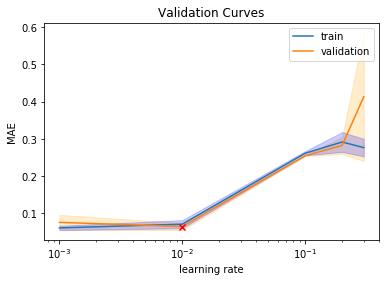

In [85]:
plt.semilogx(cv_results['param_cnn__learning_rate'], cv_results['mean_train_score'], label = 'train')
plt.semilogx(cv_results['param_cnn__learning_rate'], cv_results['mean_test_score'], label = 'validation')

# k has to transformed to float otherwise error is thrown therefore: np.array(k,dtype = float)
plt.fill_between(np.array(learning_rate, dtype = float), std_minus, std_plus, alpha=0.2, color = 'orange')
plt.fill_between(np.array(learning_rate, dtype = float), (mean_train - std_train), (mean_train + std_train), alpha=0.2, color = 'blue')
plt.scatter(best_lr, cv_results['mean_test_score'].min(), marker='x', c='red', zorder=10)

plt.title('Validation Curves')
plt.xlabel('learning rate')
plt.ylabel('MAE')
plt.legend()
plt.show()

I observe tht the the optimum value is a corner case after which both train and validation errors increase. At some other point validation error starts increasing and training error decreases which indicates overfitting.

In [86]:
# predict
y_test_pred_qt = grid_cv.best_estimator_.predict(X_test)
# invert the quantile transformation
y_test_pred = qt.inverse_transform(y_test_pred_qt.reshape(-1, 1))[:,0]

In [87]:
y_test_pred.shape

(4344,)

In [88]:
y_test.shape

(4344,)

In [89]:
cnn_mae = MAE(y_test, y_test_pred)

In [90]:
r2 = R2_score(y_test, y_test_pred, y_tr_valid)
r2

-0.02532102394680269

In [91]:
results_cnn = {'model': ['CNN'], 'r2_score': r2, 'MAE': cnn_mae}
results_cnn = pd.DataFrame(results_cnn)
np.save('results_CNNs', results_cnn)
results_cnn

,model,r2_score,MAE
0,CNN,-0.025321,60.759379


In [92]:
# due to the horizon of 8 the prediction os reduced by 8
y_test_df = pd.read_pickle('y_te.csv')
y_test_df = pd.DataFrame(y_test_df)
y_test_df['PM2.5 - prediction'] = y_test_pred
y_test_df['Residuals'] = y_test - y_test_pred
y_test_df.head()

,PM2.5,PM2.5 - prediction,Residuals
Date and Time,,,
2016-09-01 00:00:00,12.0,8.482246,3.517754
2016-09-01 01:00:00,17.0,8.482246,8.517754
2016-09-01 02:00:00,3.0,9.000000,-6.000000
2016-09-01 03:00:00,8.0,8.482246,-0.482246
2016-09-01 04:00:00,14.0,8.482246,5.517754


In [93]:
y_test_df.sample(4)

,PM2.5,PM2.5 - prediction,Residuals
Date and Time,,,
2016-10-12 05:00:00,44.0,45.0000,-1.0000
2016-10-26 02:00:00,123.0,177.0000,-54.0000
2016-11-11 09:00:00,138.0,172.0000,-34.0000
2017-02-02 10:00:00,51.0,46.0905,4.9095


In [94]:
y_test_df.to_pickle('CNNs_predictions.csv')

In [95]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [96]:
font_dict = {'fontname':'Arial', 'size':'16'}

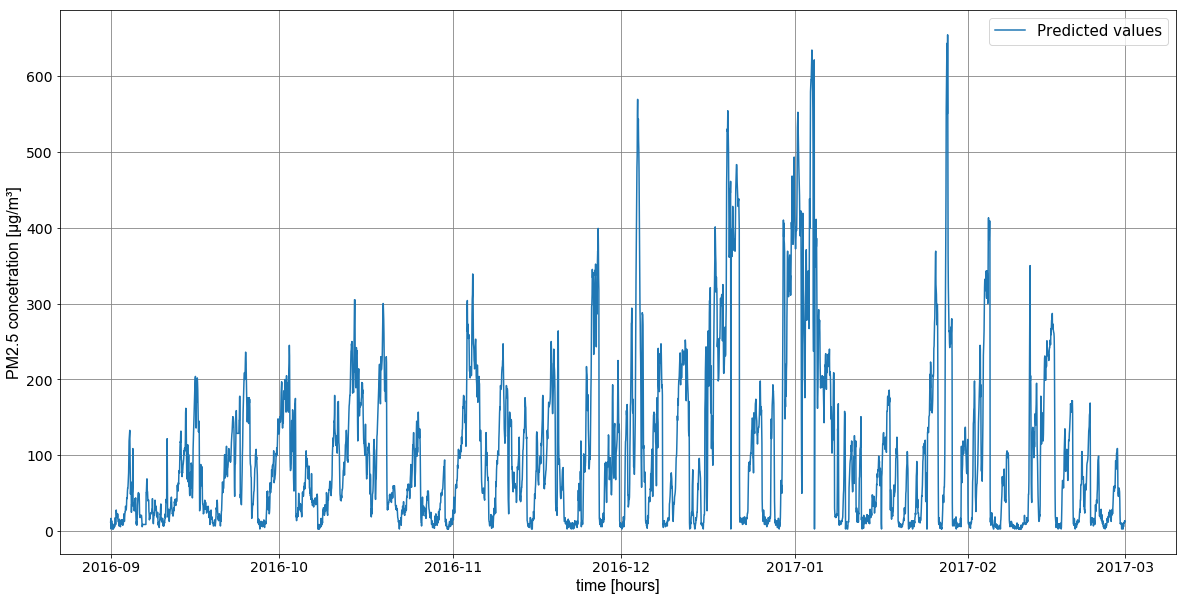

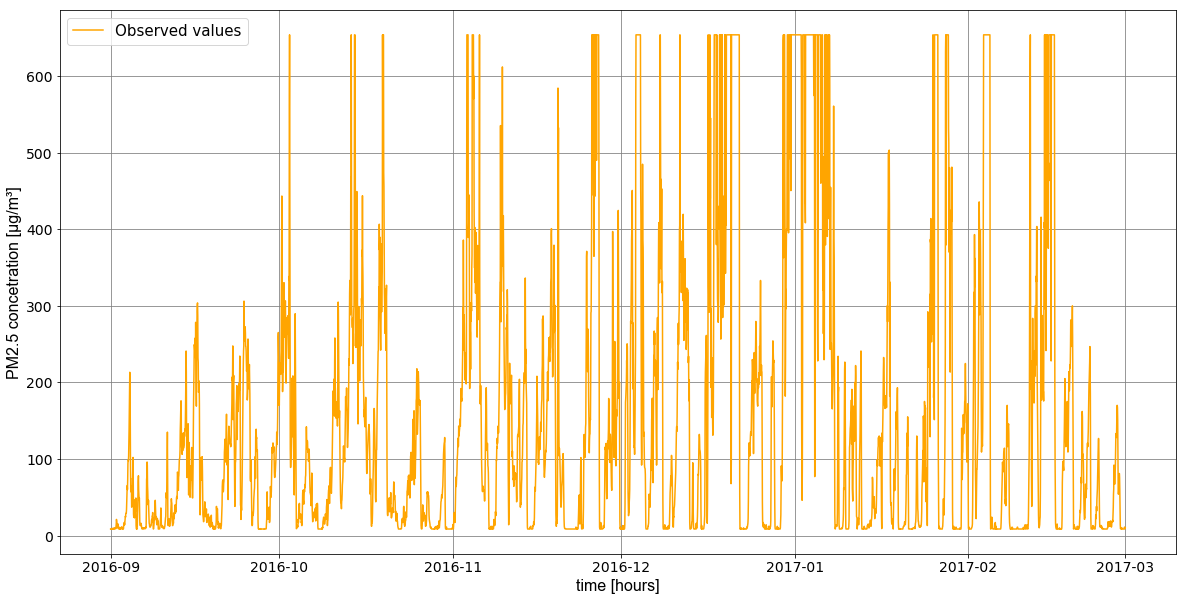

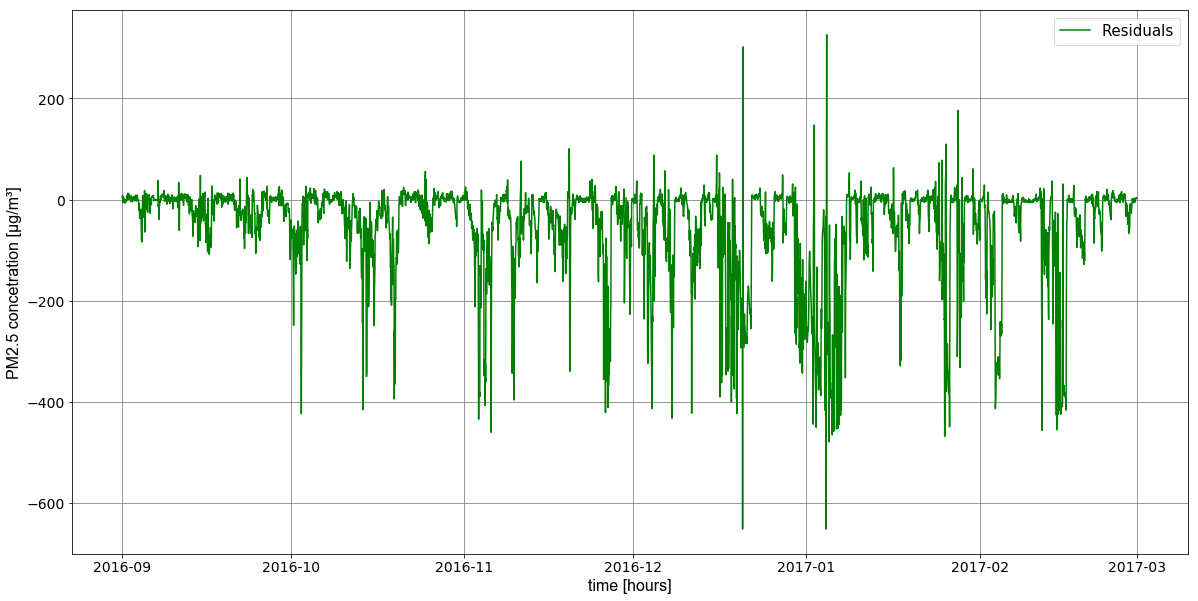

In [97]:
# plot Observations
plt.figure(figsize = (20,10))
plt.plot(y_test_df['PM2.5'], label = 'Predicted values')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()
# plot Predictions
plt.figure(figsize = (20,10))
plt.plot(y_test_df['PM2.5 - prediction'], color = 'orange', label = 'Observed values')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()
# plot Residuals
plt.figure(figsize = (20,10))
plt.plot(y_test_df['Residuals'], color = 'green', label = 'Residuals')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()

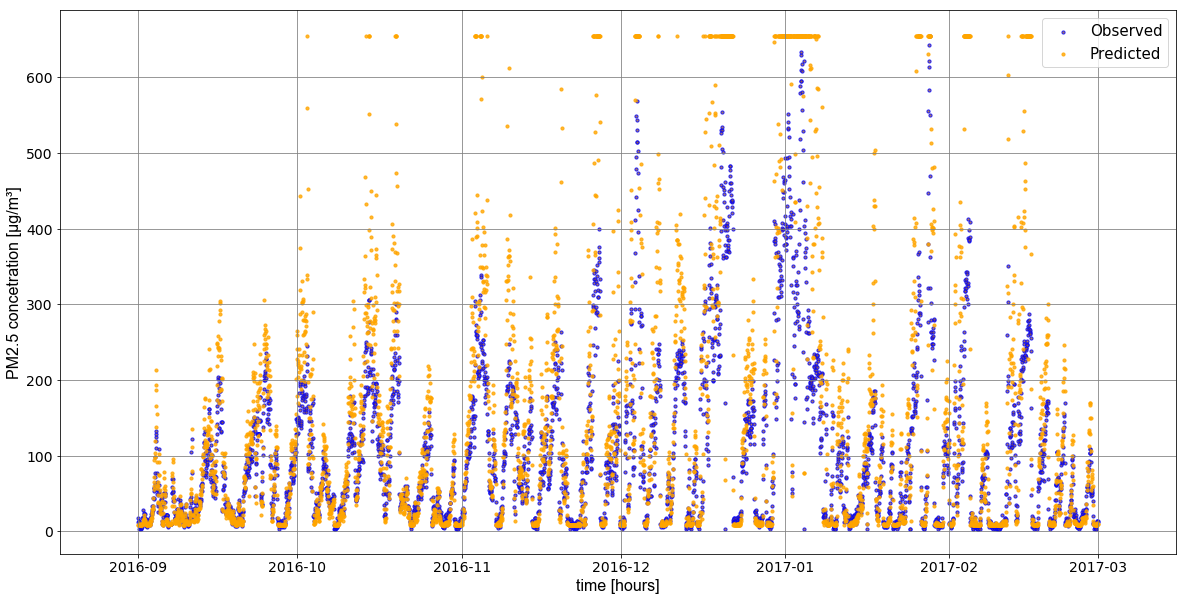

In [98]:
plt.figure(figsize = (20,10))
plt.scatter(y_test_df.index, y_test_df['PM2.5'], color = 'blue',  s=10, facecolors='C5', edgecolors='b', alpha = 0.8, label = 'Observed')
plt.scatter(y_test_df.index, y_test_df['PM2.5 - prediction'], color = 'orange', s=10, facecolors='orange', edgecolors='orange', alpha = 0.8, label = 'Predicted')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()

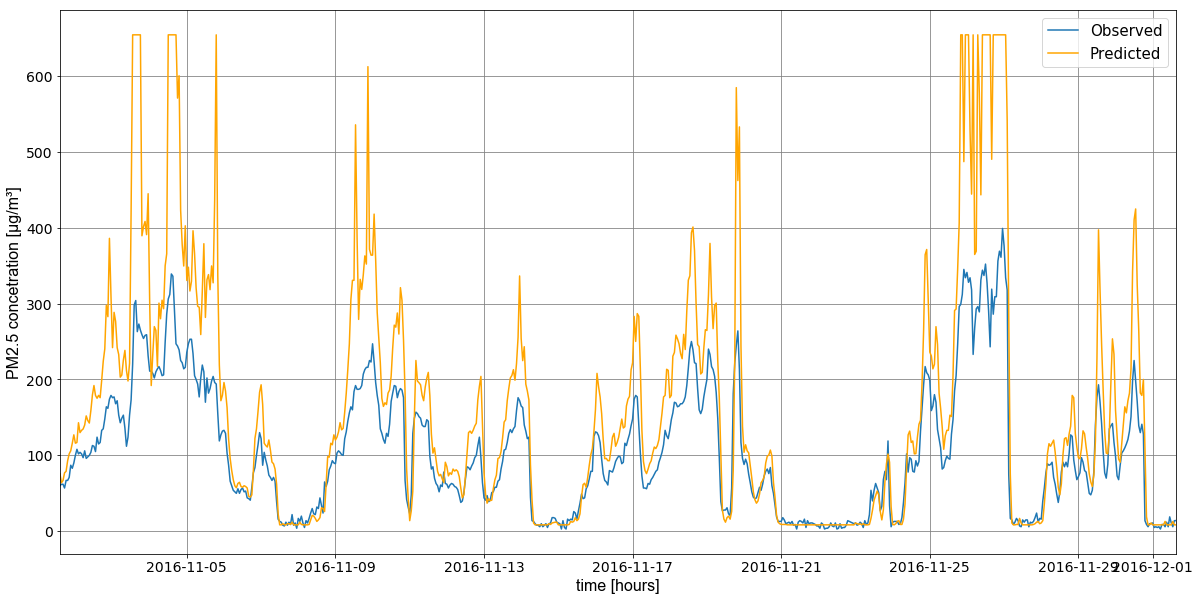

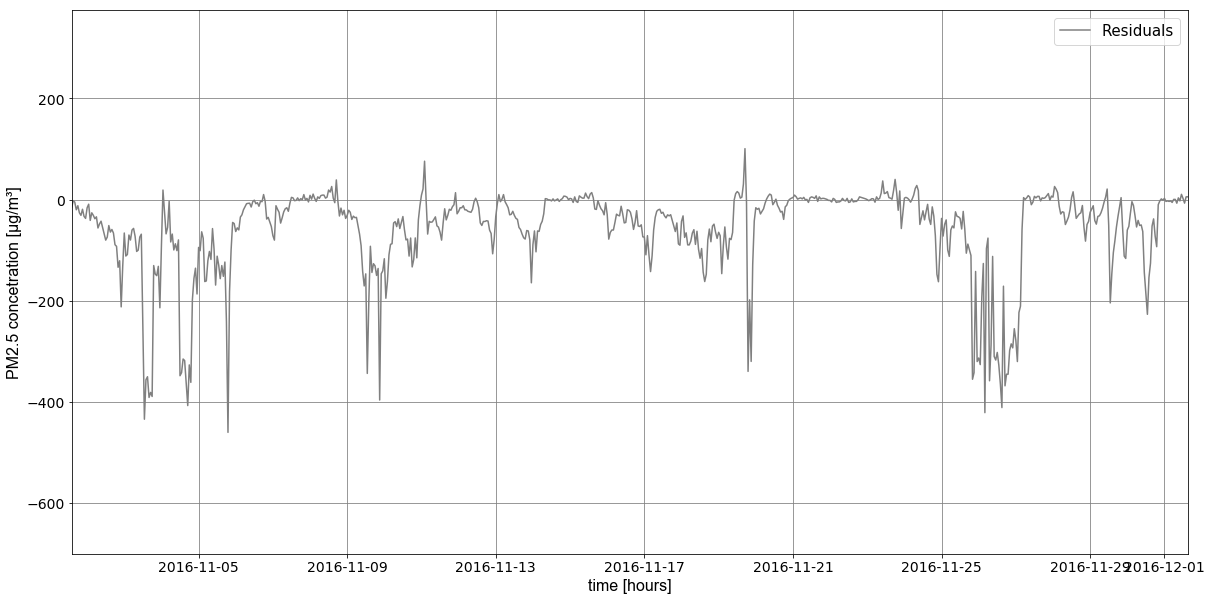

In [99]:
# plot Observations
plt.figure(figsize = (20,10))
plt.plot(y_test_df['PM2.5'], label = 'Observed')

# plot Predictions
plt.plot(y_test_df['PM2.5 - prediction'], color = 'orange', label = 'Predicted')
plt.xlim( '2016-11-1 14:00:00', '2016-12-1 15:00:00')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()

# plot Residuals
plt.figure(figsize = (20,10))
plt.plot(y_test_df['Residuals'], color = 'grey')
plt.xlim( '2016-11-1 14:00:00', '2016-12-1 15:00:00')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()

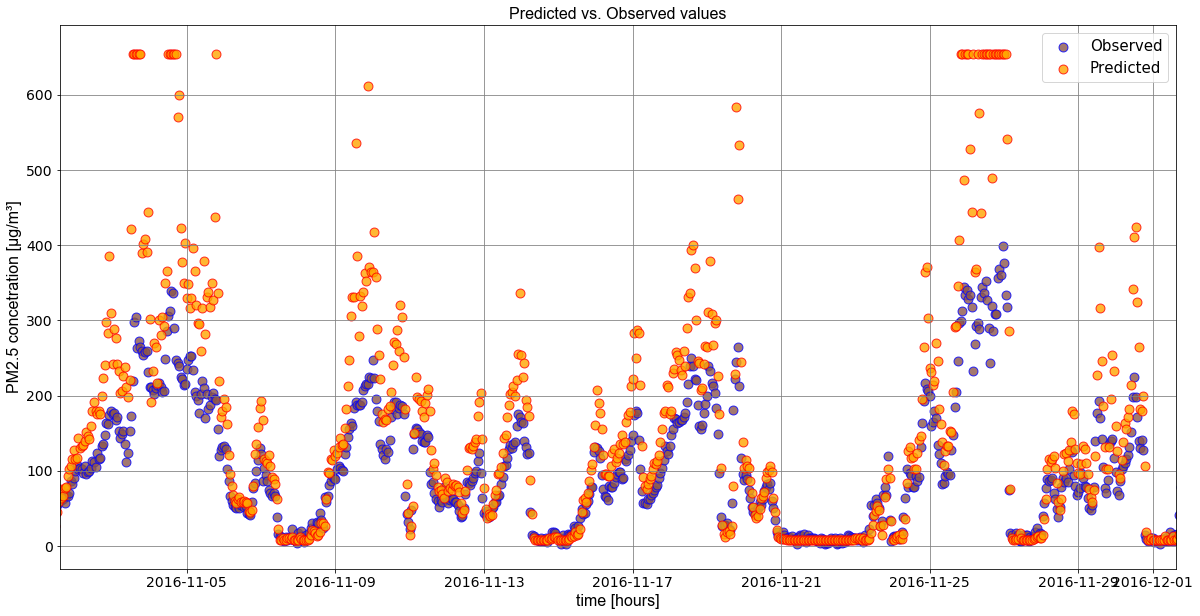

In [64]:
plt.figure(figsize = (20,10))
plt.scatter(y_test_df.index, y_test_df['PM2.5'], color = 'blue',  s=80, facecolors='C5', edgecolors='b', alpha = 0.8, label = 'Observed')
plt.scatter(y_test_df.index, y_test_df['PM2.5 - prediction'], color = 'orange', s=80, facecolors='orange', edgecolors='r', alpha = 0.8, label = 'Predicted')
plt.xlim( '2016-11-1 14:00:00', '2016-12-1 15:00:00')
plt.title('Predicted vs. Observed values', fontdict = font_dict)
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()

the results are poot with the CNN estimator clearly to make oversetimations. That is also shown by the negative residuals.